# Well Count Analysis Notebook: 2 polygons

The purpose of this code is to give percentages of wells classified as having shallow groundwater and their relative proximity to streams.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - flowlines_order#plus.shp
   - WBDHU#.shp

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'


Providing colors

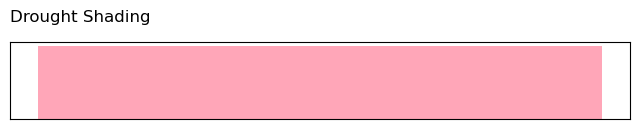

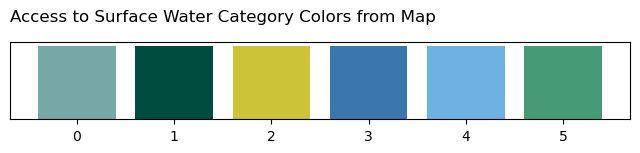

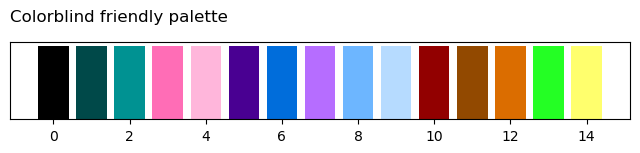

In [2]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [3]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local/Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 255849 entries, 0 to 255848
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Combo_ID    255849 non-null  object        
 1   OBJECTID_g  45684 non-null   float64       
 2   SITE_ID     45684 non-null   object        
 3   LOCAL_ID    45684 non-null   object        
 4   REGISTRY_I  234704 non-null  object        
 5   WELL_TYPE   45684 non-null   object        
 6   DD_LAT      45684 non-null   float64       
 7   DD_LONG     45684 non-null   float64       
 8   LAT_NAD27   45684 non-null   object        
 9   LONG_NAD27  45684 non-null   object        
 10  WELL_ALT    45684 non-null   float64       
 11  WATER_USE_  45626 non-null   object        
 12  WELL_DEPTH  215436 non-null  float64       
 13  CASE_DIAM   33813 non-null   float64       
 14  WL_COUNT    45684 non-null   f

In [4]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'date':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local/Wells55_GWSI_WLTS_DB_monthly.csv


,Combo_ID,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,82721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00
3,83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


### From here down is where you can rerun the code to generate graphs

In [5]:
# Put your huc number here
huc_num = '4'

In [6]:
# Read in the reach shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = '/flowlines_order4plus.shp'
# filename_shapeile = '/huc'+huc_num+'flowlines_order3plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(outputpath+filename_shapeile)
shapefile = gp.read_file(filepath)
# shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [7]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,geometry
0,149136270,Dodson Wash,15020005000065,5,None,1502,Little Colorado,"LINESTRING Z (-110.22189 34.34674 0, -110.2217..."
1,149136272,Dodson Wash,15020005000066,5,None,1502,Little Colorado,"LINESTRING Z (-110.22271 34.33082 0, -110.2227..."
2,149136273,Dodson Wash,15020005000067,5,None,1502,Little Colorado,"LINESTRING Z (-110.22282 34.32381 0, -110.2227..."
3,149136329,Dodson Wash,15020005000068,5,None,1502,Little Colorado,"LINESTRING Z (-110.22374 34.32175 0, -110.2237..."
4,149133749,Dodson Wash,15020005000064,5,None,1502,Little Colorado,"LINESTRING Z (-110.21985 34.36593 0, -110.2201..."
...,...,...,...,...,...,...,...,...
92007,79196263,None,14070003000485,5,None,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-111.62334 38.30524 0, -111.6232..."
92008,79196323,None,14070003000485,5,None,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-111.63217 38.30203 0, -111.6321..."
92009,79196161,None,14070003002105,5,None,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-111.72004 38.30775 0, -111.7196..."
92010,78979158,Upper Valley Creek,14070005000135,5,None,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-111.77497 37.72374 0, -111.7747..."


<Axes: >

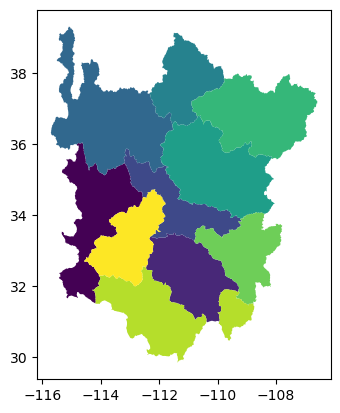

In [10]:
# Read in the reach shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'WBDHU'+huc_num+'.shp'
# filename_shapeile = '/huc'+huc_num+'flowlines_order3plus.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapeile)
filepath = os.path.join(shapepath+"/NHD_H_Arizona_State_Shape/Shape/",filename_shapeile)
shapefile_wbd = gp.read_file(filepath)
shapefile_wbd = shapefile_wbd.rename(columns = {'huc'+huc_num:'huc'+huc_num+'_wb',})
shapefile_wbd.plot(cmap='viridis')


Take a look at the columns and variables

In [11]:
shapefile_wbd = shapefile_wbd[['huc'+huc_num+'_wb','geometry']]
shapefile_wbd

,huc4_wb,geometry
0,1503,"POLYGON ((-114.62325 36.0304, -114.62293 36.03..."
1,1505,"POLYGON ((-111.47785 33.48853, -111.47737 33.4..."
2,1506,"POLYGON ((-113.09819 35.86434, -113.09792 35.8..."
3,1501,"POLYGON ((-115.0786 39.30054, -115.07836 39.29..."
4,1407,"POLYGON ((-111.47581 39.1245, -111.47546 39.12..."
5,1502,"POLYGON ((-110.57591 36.793, -110.57553 36.792..."
6,1408,"POLYGON ((-109.31179 37.98113, -109.31014 37.9..."
7,1504,"POLYGON ((-108.65524 34.07748, -108.65511 34.0..."
8,1508,"MULTIPOLYGON (((-112.53359 32.54199, -112.5333..."
9,1507,"POLYGON ((-112.1581 34.71632, -112.15808 34.71..."


In [12]:
# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""
water_designation = swdom 

Merging the databases takes a little time - Approximately 3 minutes

In [13]:
# Merge the shapefile with the master database

shapefile_wbd = shapefile_wbd.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile_wbd, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


Master_ADWR_database_noduplicates.shp and WBDHU4.shp join complete.


Check to make sure the merged dataframe looks good

In [14]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,ADDRESS2,CITY,STATE,ZIP,ZIP4,WATER_US_1,SITE_USE,geometry,index_right,huc4_wb
0,060000,NaN,None,None,060000,None,NaN,NaN,None,None,...,950 W. ELLIOTT RD. STE 122,TEMPE,AZ,85284,None,DEWATERING,WATER PRODUCTION,POINT (423912.1 3646244),1,1505
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,None,PHOENIX,AZ,85016,None,INDUSTRIAL,WATER PRODUCTION,POINT (361260.194 3739336.681),9,1507
2,082721,NaN,None,None,082721,None,NaN,NaN,None,None,...,None,PARADISE VALLEY,AZ,85253,None,DOMESTIC,WATER PRODUCTION,POINT (298366.4 3708927),9,1507
3,083226,NaN,None,None,083226,None,NaN,NaN,None,None,...,None,WILLCOX,AZ,85643,None,DOMESTIC,WATER PRODUCTION,POINT (612466.5 3573775),1,1505
4,083578,NaN,None,None,083578,None,NaN,NaN,None,None,...,None,TUMACACORI,AZ,85640,None,DOMESTIC,WATER PRODUCTION,POINT (496526.6 3495617),1,1505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255844,931600,NaN,None,None,931600,None,NaN,NaN,None,None,...,None,DEWEY,AZ,86327,None,DOMESTIC,None,POINT (386628.6 3805859),9,1507
255845,931601,NaN,None,None,931601,None,NaN,NaN,None,None,...,None,PRESCOTT,AZ,86303,None,DOMESTIC,None,POINT (365836.6 3856389),2,1506
255846,931602,NaN,None,None,931602,None,NaN,NaN,None,None,...,None,RALEIGH,NC,27606,None,NO WATER USE,None,POINT (505740 3466928),1,1505
255847,931603,NaN,None,None,931603,None,NaN,NaN,None,None,...,None,TUCSON,AZ,85712,None,DOMESTIC,None,POINT (619340.3 3541818),1,1505


In [15]:
static_geo = static_geo.drop(columns='index_right')
static_geo.columns

Index(['Combo_ID', 'OBJECTID_g', 'SITE_ID', 'LOCAL_ID', 'REGISTRY_I',
       'WELL_TYPE', 'DD_LAT', 'DD_LONG', 'LAT_NAD27', 'LONG_NAD27', 'WELL_ALT',
       'WATER_USE_', 'WELL_DEPTH', 'CASE_DIAM', 'WL_COUNT', 'WL_DTW',
       'WL_ELEV', 'SOURCE', 'IDXBK', 'DRILL_DATE', 'LASTWLDATE', 'QUASI_IDX_',
       'GOES_ENABL', 'TRANSDUCER', 'IDXBK2', 'FREQUENCY', 'Original_D',
       'OBJECTID_w', 'PROGRAM', 'OWNER_NAME', 'RGR_PUMP_D', 'WELLTYPE',
       'WELL_TYPE_', 'DLIC_NUM', 'APPROVED', 'INSTALLED', 'WATER_LEVE',
       'CASING_DEP', 'CASING_DIA', 'CASING_TYP', 'PUMP_TYPE', 'PUMP_POWER',
       'PUMPRATE', 'TESTEDRATE', 'DRAW_DOWN', 'COMPLETION', 'DRILL_LOG',
       'WELL_CANCE', 'CADASTRAL', 'COUNTY', 'WATERSHED', 'BASIN_NAME',
       'SUBBASIN_N', 'AMA', 'QUAD_CODE', 'WHOLE_TOWN', 'HALF_TOWNS',
       'NORTHSOUTH', 'WHOLE_RANG', 'HALF_RANGE', 'EASTWEST', 'SECTION',
       'QUARTER_16', 'QACRE160DI', 'QUARTER_40', 'QACRE40DIR', 'QUARTER_10',
       'QACRE10DIR', 'UTM_X_METE', 'UTM_Y_METE'

In [16]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col+'_wb','WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1340034797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [17]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168101 entries, 0 to 168100
Columns: 1424 entries, Combo_ID to WELL_TYPE_
dtypes: float64(1421), int64(1), object(2)
memory usage: 1.8+ GB


In [18]:
combo

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1507,1000.00,NON-EXEMPT
82721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1507,0.00,NON-EXEMPT
83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,162.00,1505,162.00,EXEMPT
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
83716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1505,0.00,EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1505,0.00,NON-EXEMPT
627558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1505,0.00,NON-EXEMPT
627559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1505,0.00,EXEMPT


Here we only want shallow wells (anything less than 200ft) and to remove wells with default 0 drilling depth values

In [19]:
# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
test


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,162.00,1505,162.00,EXEMPT
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504,80.00,NON-EXEMPT
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,130.00,NON-EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,58.00,NON-EXEMPT
627546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,103.00,NON-EXEMPT
627547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1502,150.00,NON-EXEMPT


This portion of the code makes sure a well isn't being counted multiple times

In [20]:
combo_copy = test.copy()
df = combo_copy.reset_index()  # Moves well_ID from index to a column (if needed)
df = df.drop_duplicates(subset=["Combo_ID", Naming_col+"_wb"])
df = df.set_index("Combo_ID")
df


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,162.00,1505,162.00,EXEMPT
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504,80.00,NON-EXEMPT
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,130.00,NON-EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,58.00,NON-EXEMPT
627546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,103.00,NON-EXEMPT
627547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1502,150.00,NON-EXEMPT


In [21]:
# Grouping the appropriate column
# combo_copy = combo.copy()
combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


In [22]:
combo_copy

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan,huc4_wb
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00,1505
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
627546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
627547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1502


This bit of code will remove any wells with anomalous readings (e.g. anything greater than 500ft)

In [28]:
df = combo_copy.copy()

# Example: Your dataframe (df) has columns as YYYY-MM and 'Combo_ID' + 'huc12'
# Step 1: Filter columns for readings after 1980
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']

# Step 2: Find wells with any reading > 500 ft in these columns
mask = (df[date_cols] > 200).any(axis=1)

# Step 3: Drop wells that meet this condition
df_filtered = df[~mask]

# Now df_filtered contains only wells that never exceeded 500 ft after 1980
df_filtered


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan,huc4_wb
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00,1505
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00,1507
627543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
627546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505


In [44]:
df = df_filtered.copy()
df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']  # Keep only years >= 1980

# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col+"_wb"] + date_cols]
df


,Combo_ID,huc4_wb,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan
0,83226,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00
1,83578,1505,NaN,NaN,NaN,12.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84067,1505,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84614,1504,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84630,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49438,627542,1507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00
49439,627543,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49440,627546,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49441,627547,1502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df = df.drop(columns='nan')

In [66]:
df

,Combo_ID,huc4_wb,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,...,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09
0,83226,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83578,1505,NaN,NaN,NaN,12.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84067,1505,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84614,1504,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84630,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49438,627542,1507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49439,627543,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49440,627546,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49441,627547,1502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df['1980-01'].iloc[0]

np.float64(nan)

In [69]:
import seaborn as sns

# df = df_filtered.copy()

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col+"_wb"], var_name='Date', value_name='DTW')

# Convert 'Date' column to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted = df_melted.dropna(subset=['DTW'])

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion


# Classify DTW values into categories
def classify_dtw(dtw):
    if dtw < 2:
        return 'Near Surface (<2m)'
    elif 2 <= dtw < 5:
        return 'Very Shallow (2-5m)'
    elif 5 <= dtw < 10:
        return 'Shallow (5-10m)'
    else:
        return 'Deep (10-61m)'

df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw)

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()

# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()

# Rename for clarity
summary_df.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)

summary_df

,Decade,DTW_Category,Well Count
0,1980,Deep (10-200m),5620
1,1980,Near Surface (<2m),1595
2,1980,Shallow (5-10m),2193
3,1980,Very Shallow (2-5m),1588
4,1990,Deep (10-200m),9273
5,1990,Near Surface (<2m),2097
6,1990,Shallow (5-10m),2610
7,1990,Very Shallow (2-5m),2214
8,2000,Deep (10-200m),5630
9,2000,Near Surface (<2m),306


In [70]:
df_melted

,Combo_ID,huc4_wb,Date,DTW,DTW_meters,DTW_Category,Decade
2,84067,1505,1980-01-01,0.00,0.00,Near Surface (<2m),1980
10,84810,1502,1980-01-01,28.00,8.53,Shallow (5-10m),1980
12,84824,1507,1980-01-01,45.00,13.72,Deep (10-200m),1980
13,84828,1506,1980-01-01,18.00,5.49,Shallow (5-10m),1980
17,84956,1506,1980-01-01,24.00,7.32,Shallow (5-10m),1980
...,...,...,...,...,...,...,...
26460679,239498,1504,2024-08-01,37.00,11.28,Deep (10-200m),2020
26460830,240344,1504,2024-08-01,72.00,21.95,Deep (10-200m),2020
26460831,240350,1504,2024-08-01,22.00,6.71,Shallow (5-10m),2020
26510143,239626,1503,2024-09-01,15.00,4.57,Very Shallow (2-5m),2020


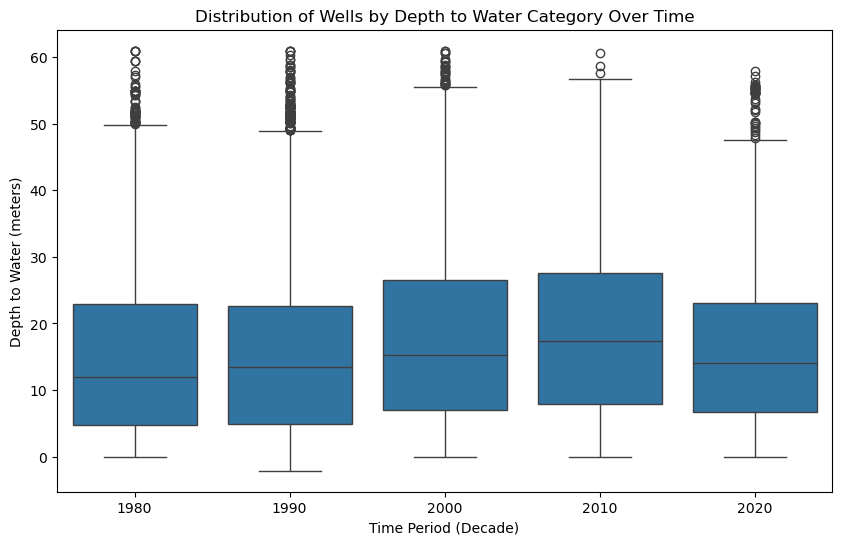

In [81]:
# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, 
            x='Decade',
            y='DTW_meters', 
            # hue='Decade', 
            # palette='viridis'
            )

plt.title('Distribution of Wells by Depth to Water Category Over Time')
plt.xlabel('Time Period (Decade)')
plt.ylabel('Depth to Water (meters)')
# plt.legend(title='DTW Category')
plt.xticks(rotation=0)
plt.show()


/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/319175597.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


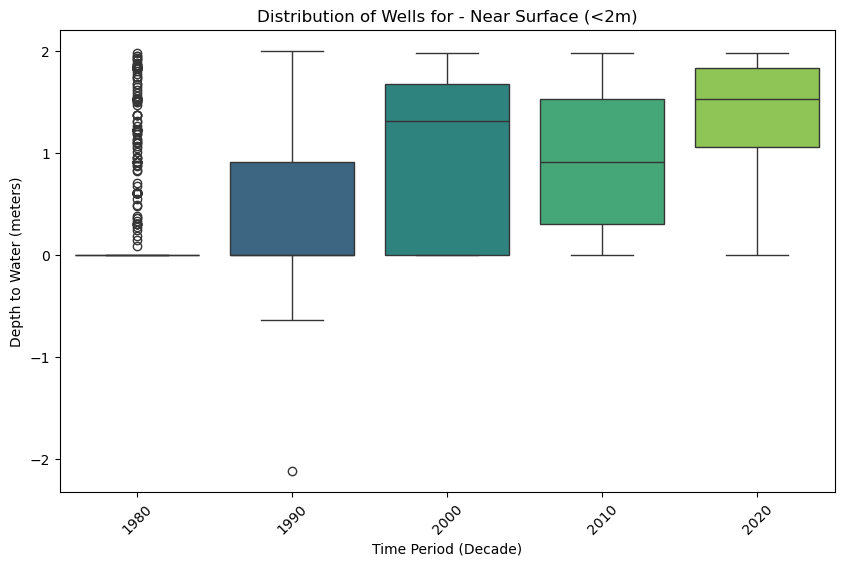

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/319175597.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


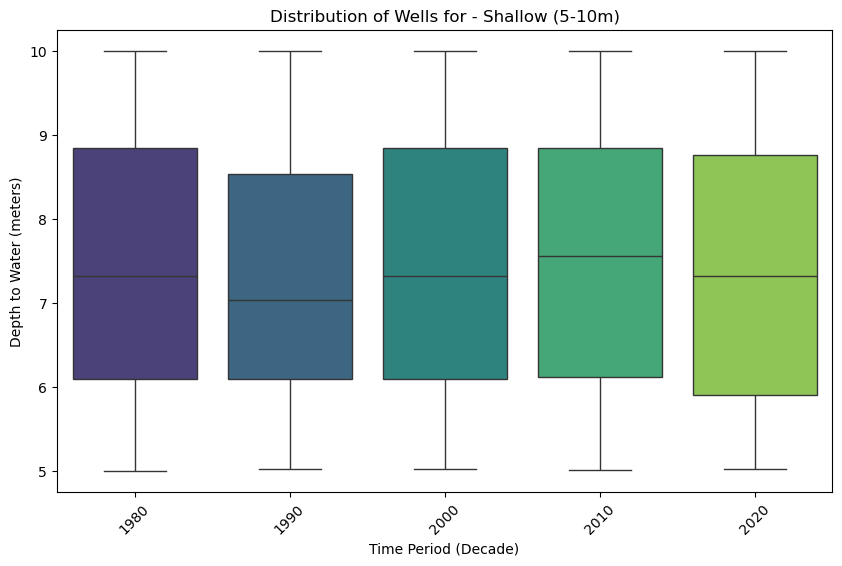

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/319175597.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


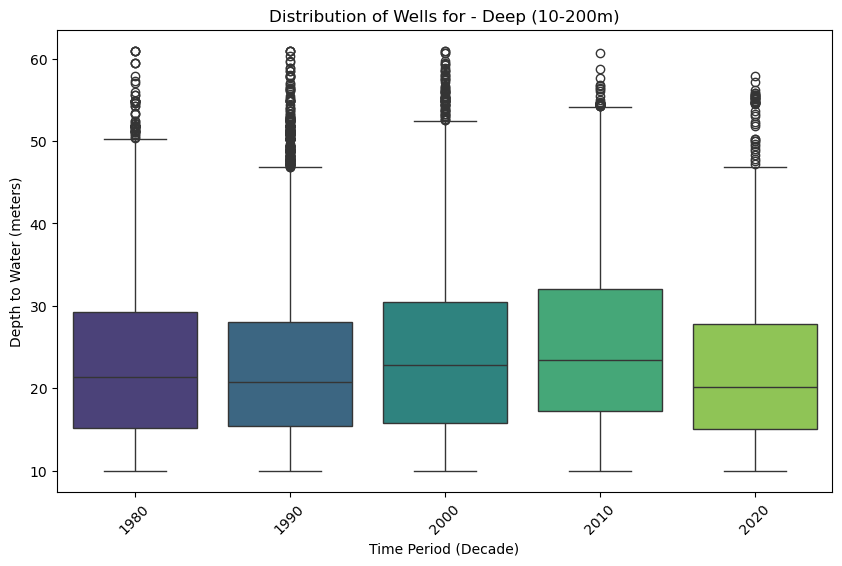

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/319175597.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


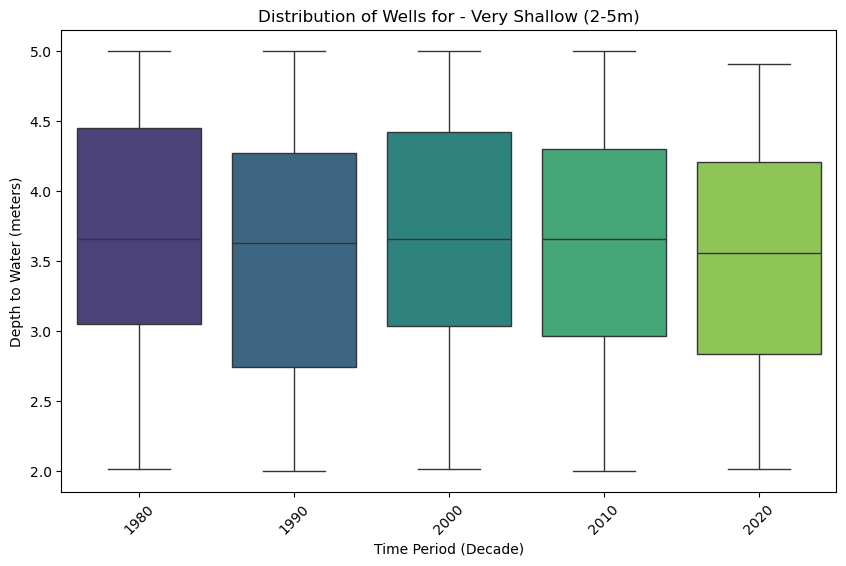

In [87]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()

# Loop through each DTW category and create a box plot
for category in dtw_categories:
    plt.figure(figsize=(10, 6))
    
    # Subset data for the current category
    subset = df_melted[df_melted['DTW_Category'] == category]

    # Create the box plot
    sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')

    # Titles and labels
    plt.title(f'Distribution of Wells for - {category}')
    plt.xlabel('Time Period (Decade)')
    plt.ylabel('Depth to Water (meters)')
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


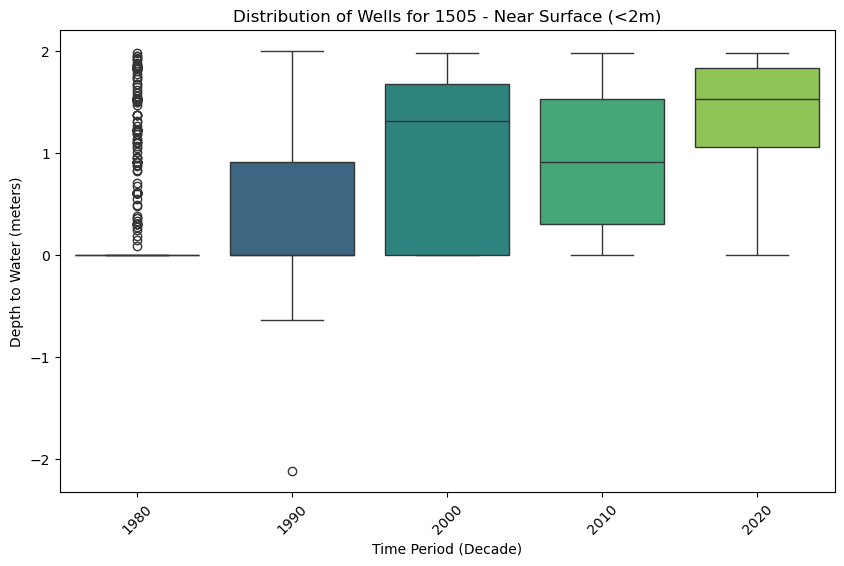

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


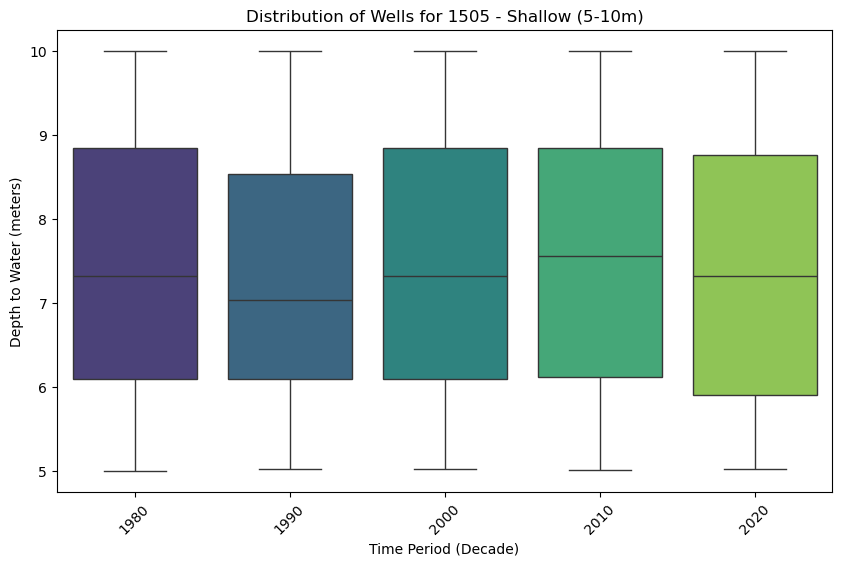

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


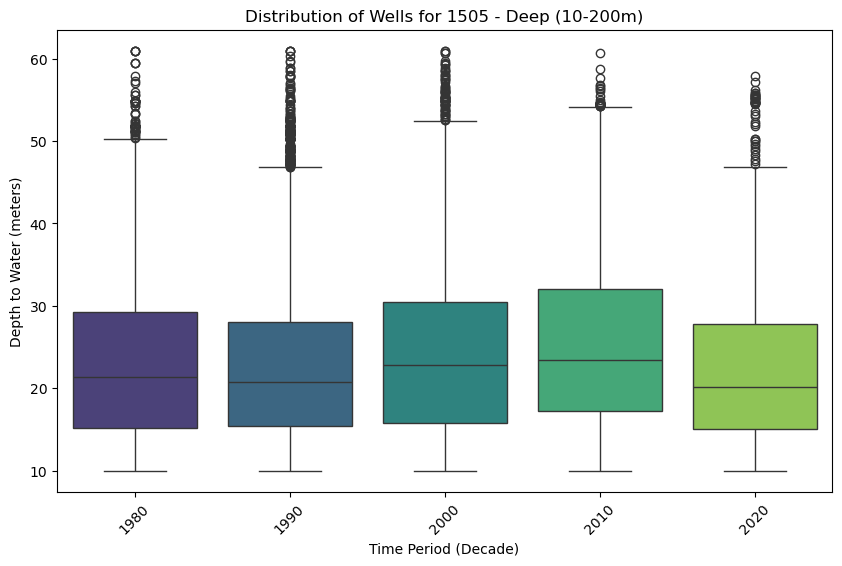

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


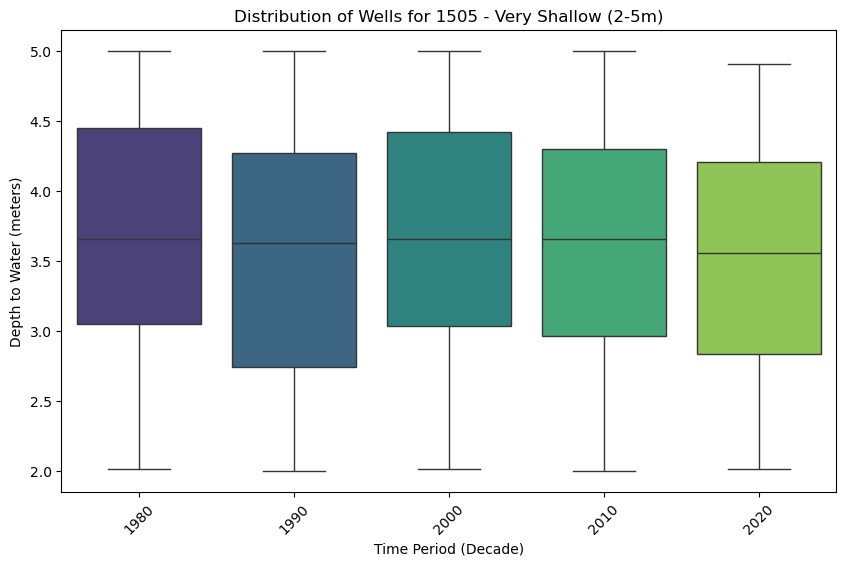

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


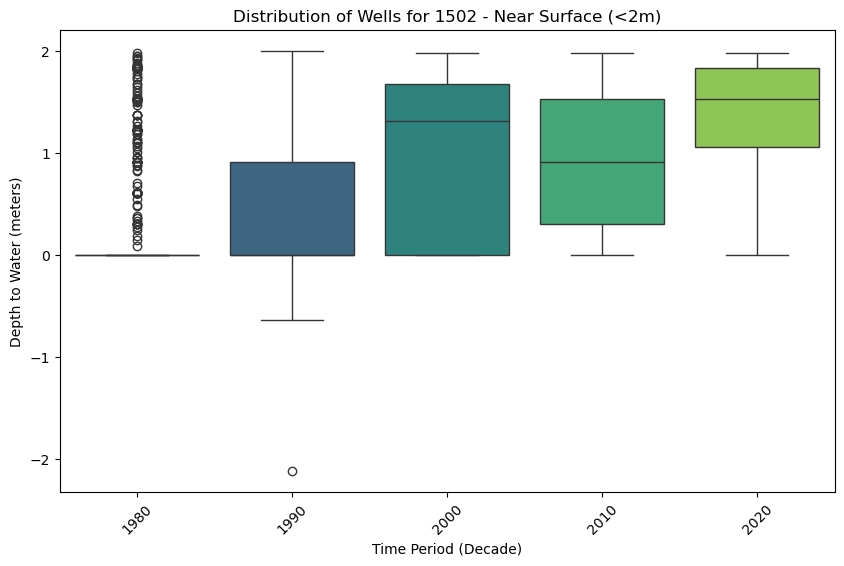

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


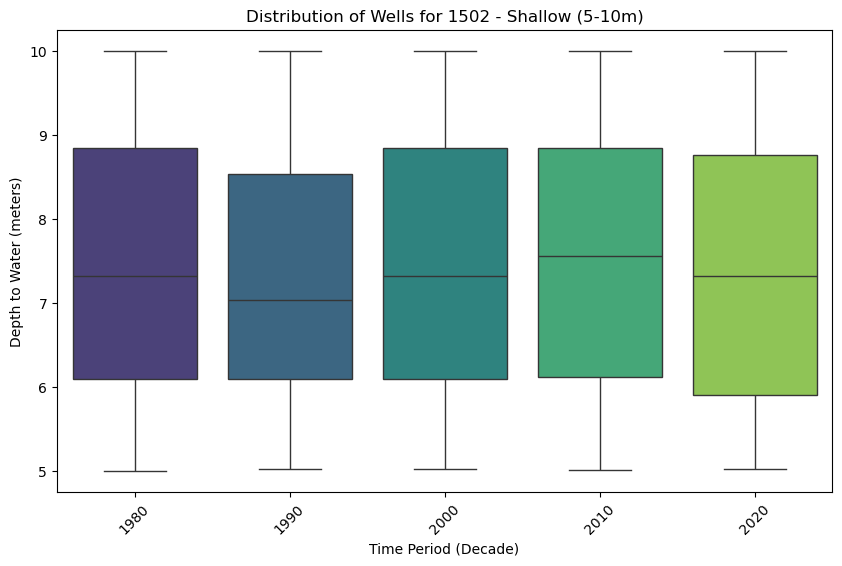

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


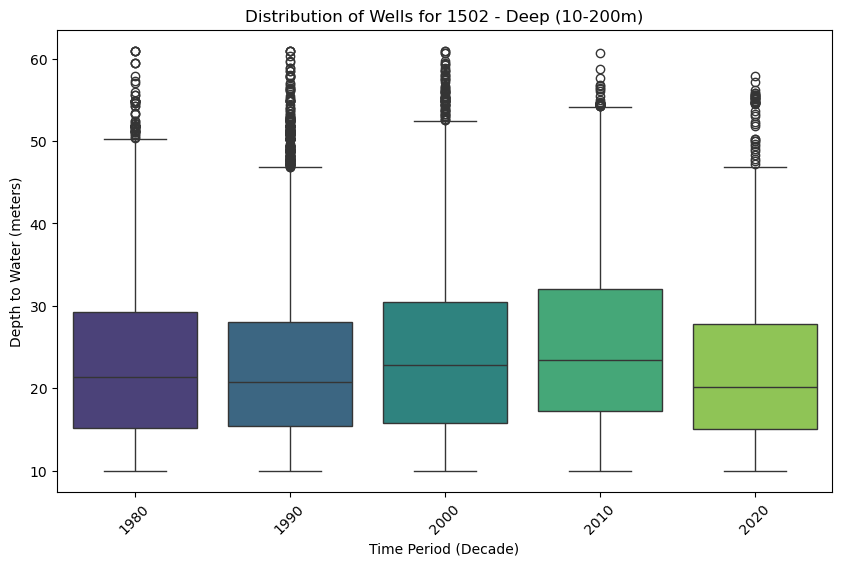

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


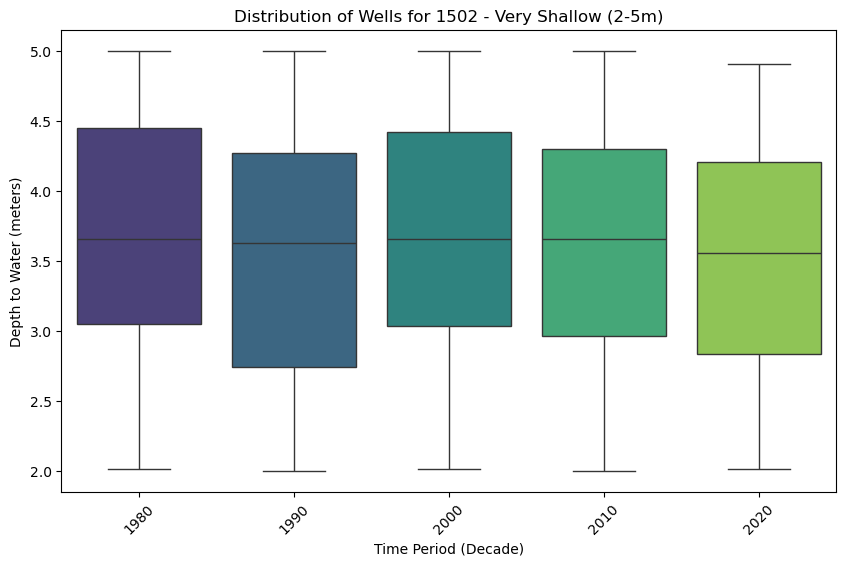

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


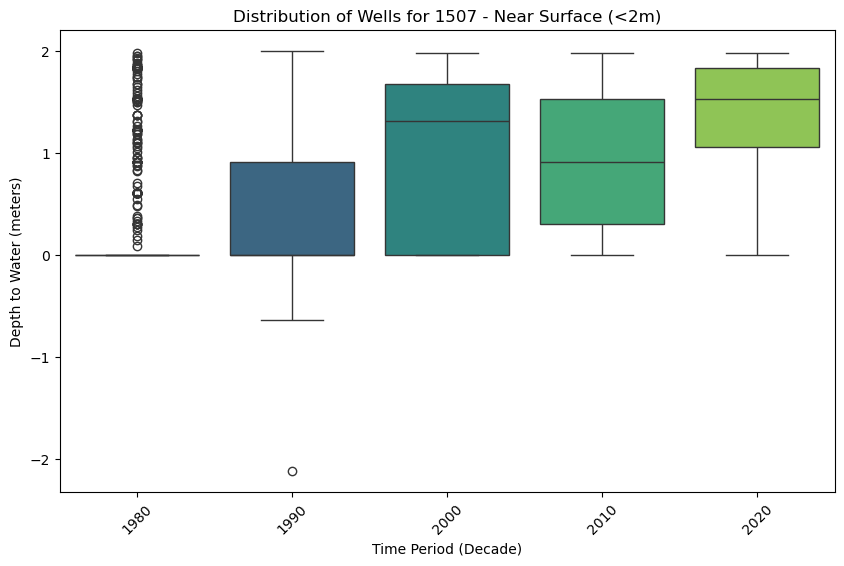

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


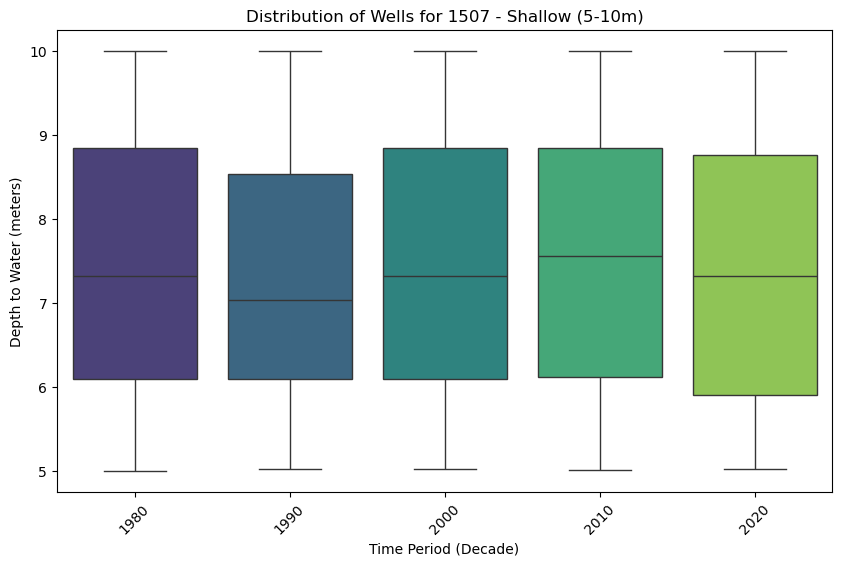

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


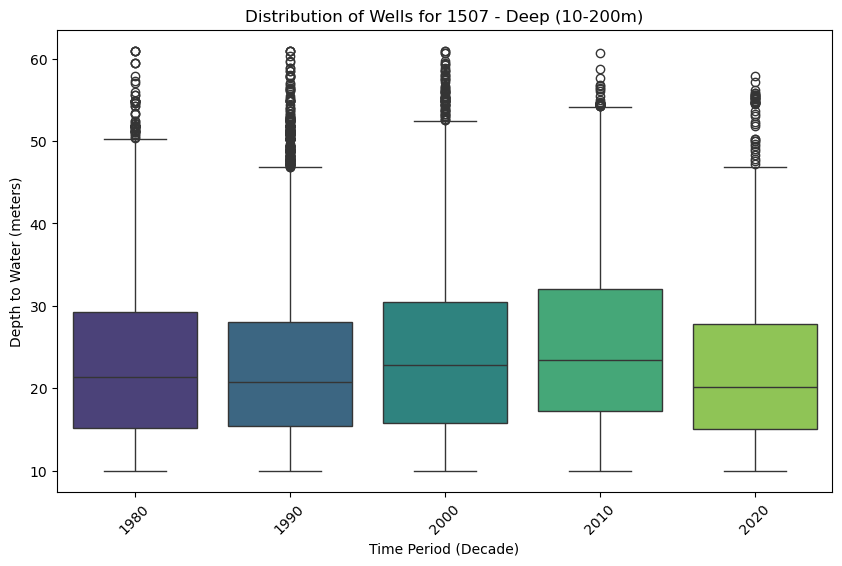

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


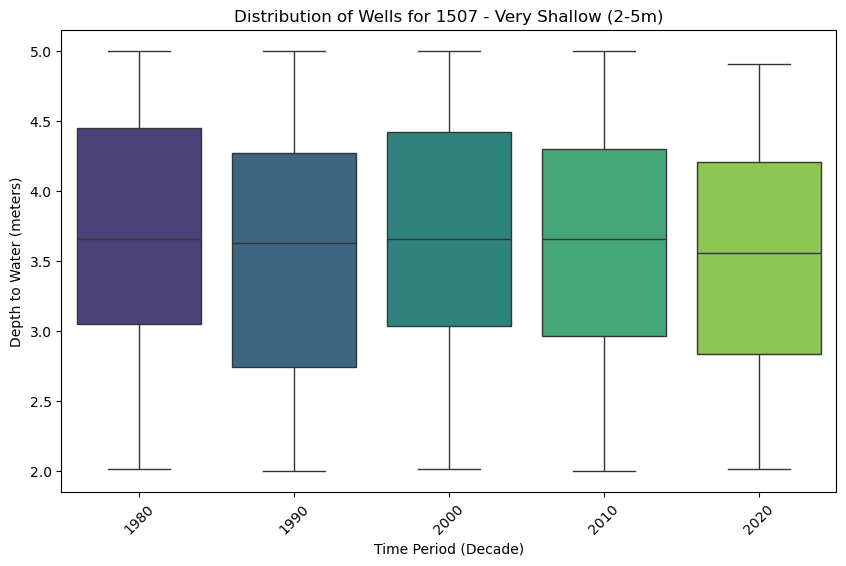

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


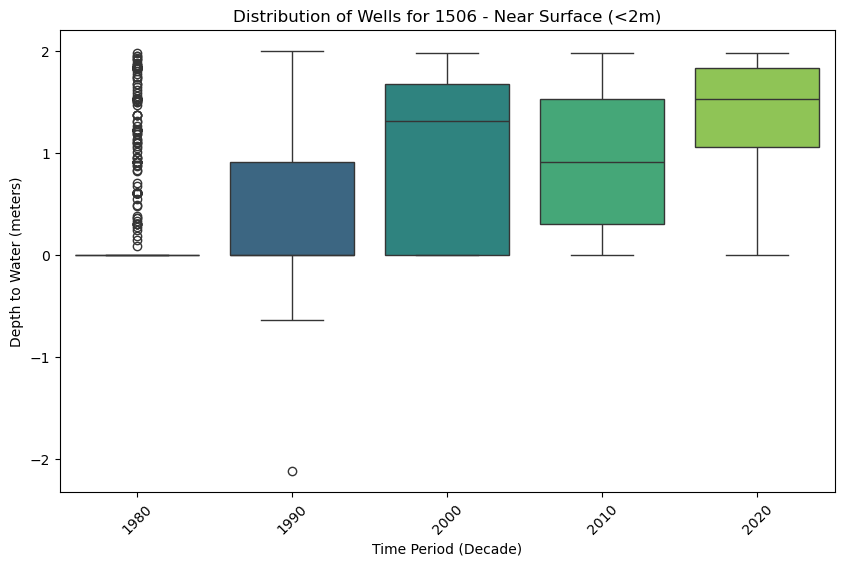

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


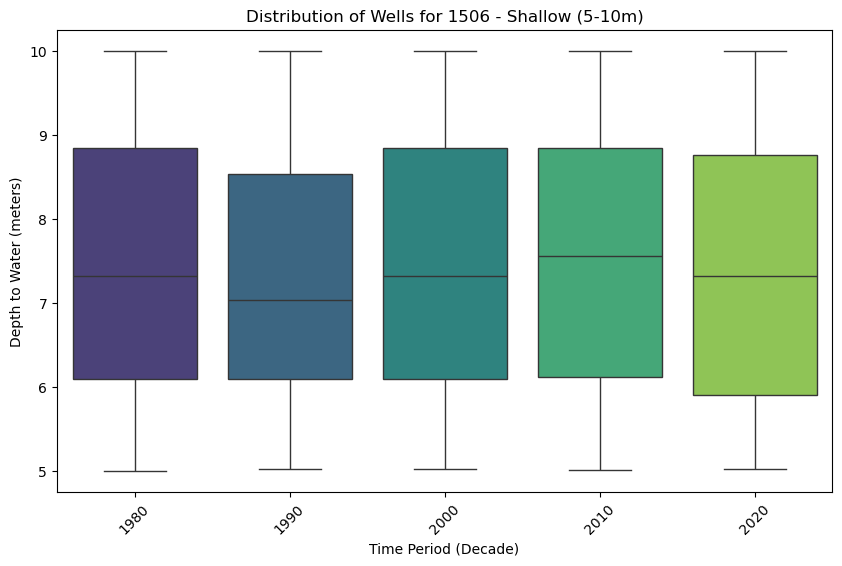

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


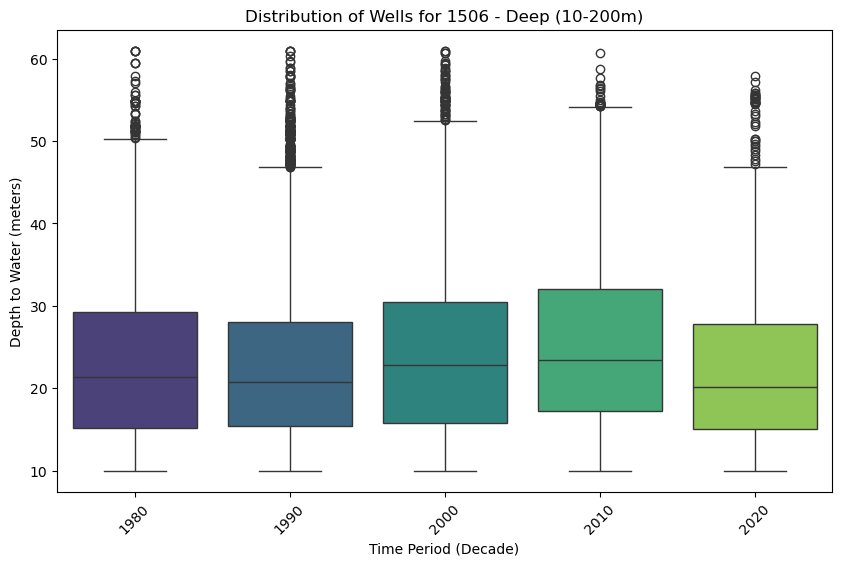

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


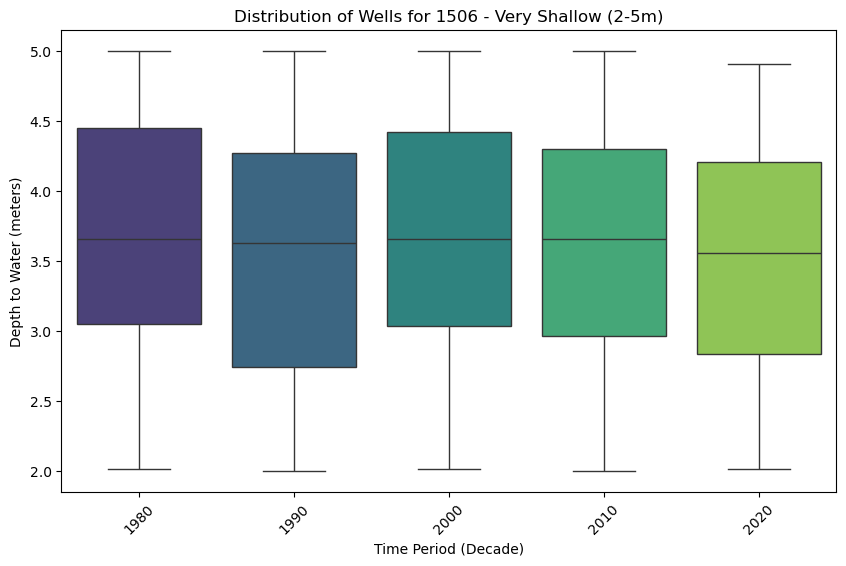

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


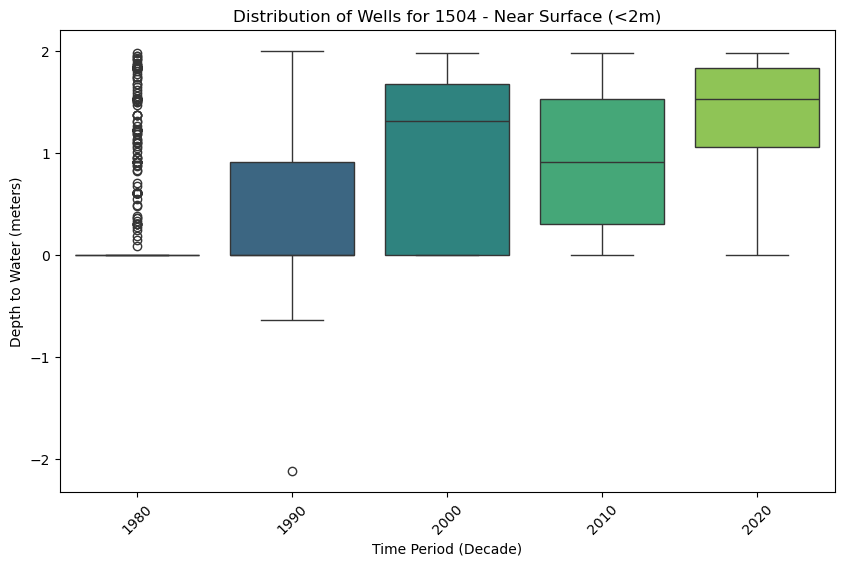

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


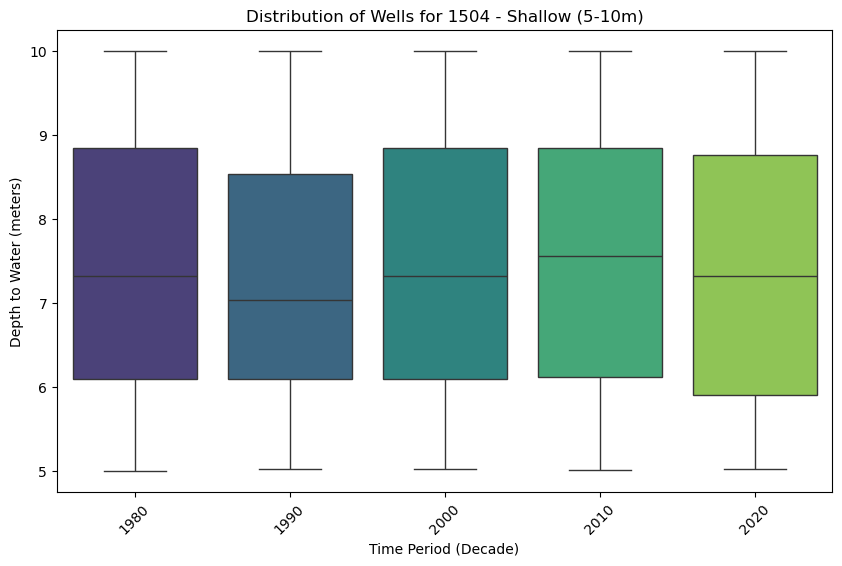

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


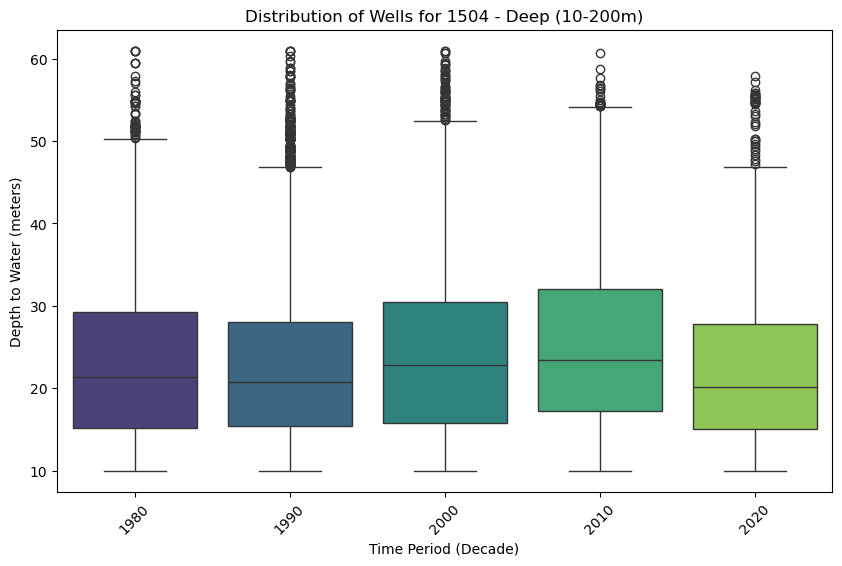

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


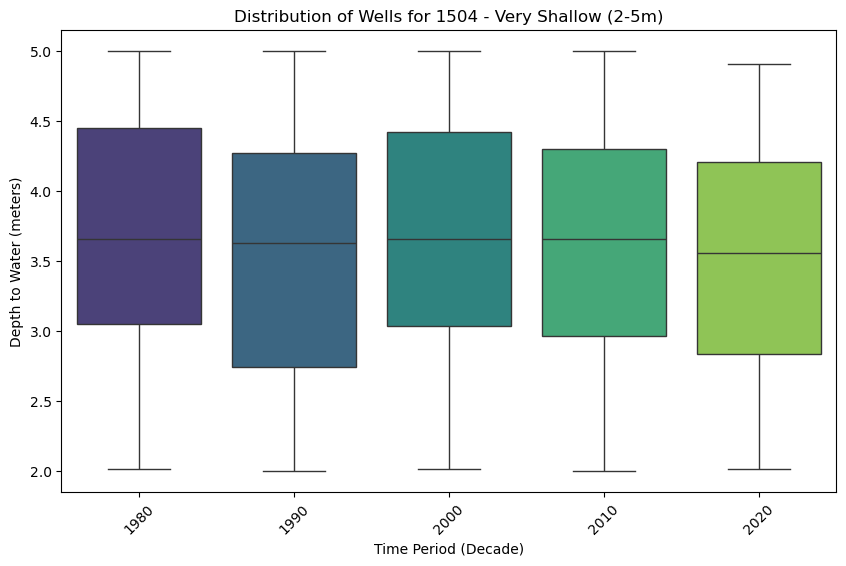

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


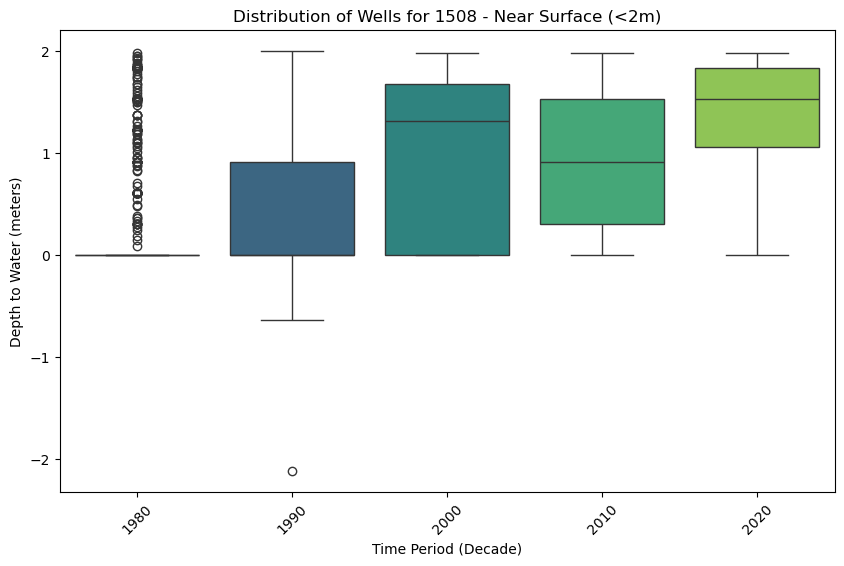

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


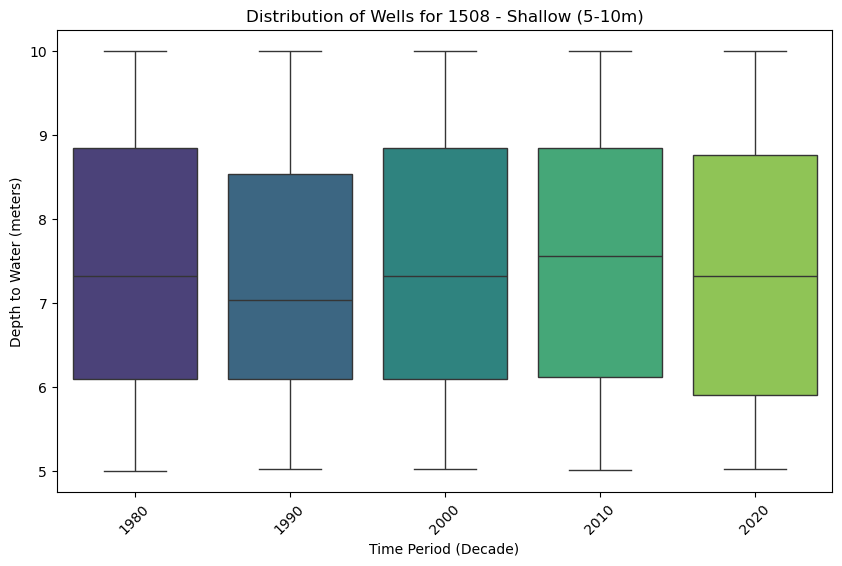

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


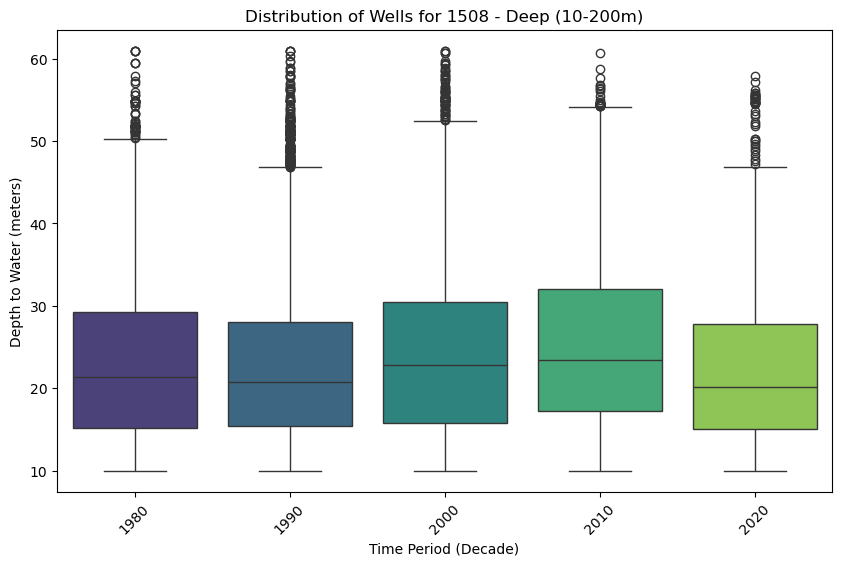

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


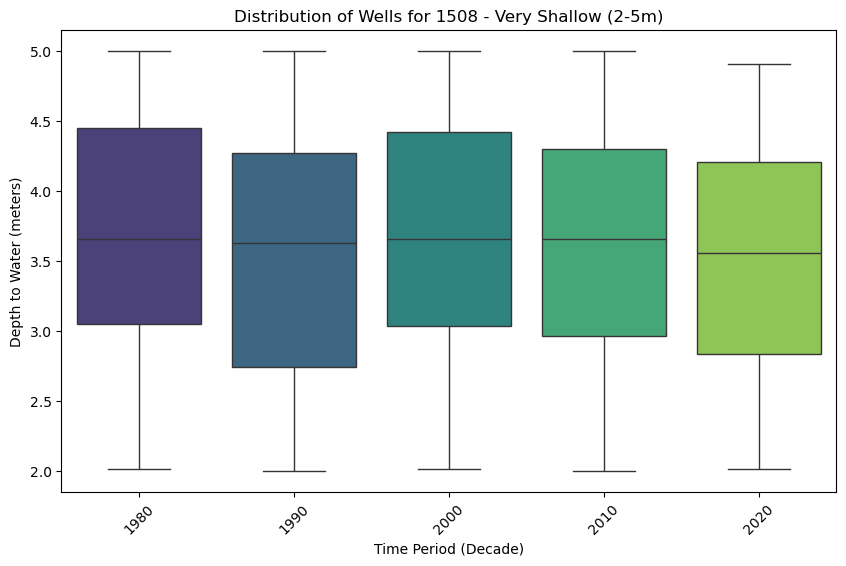

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


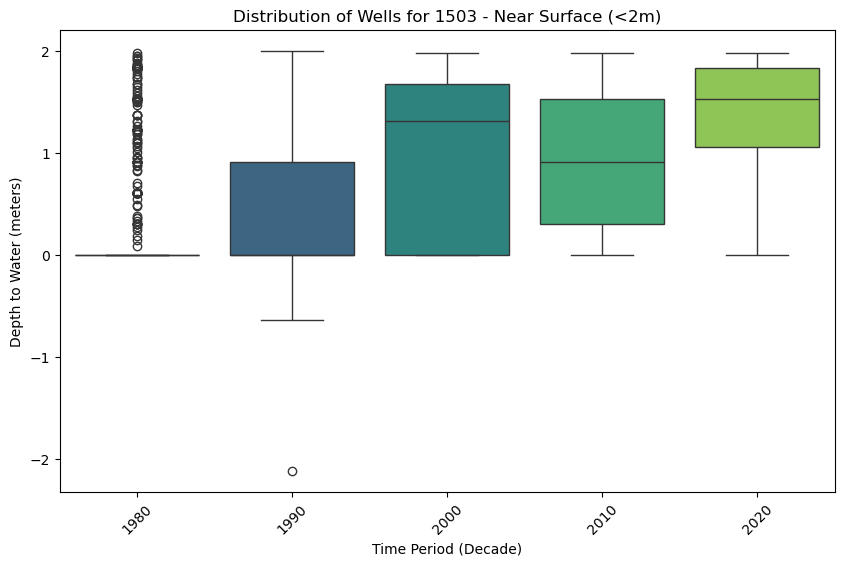

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


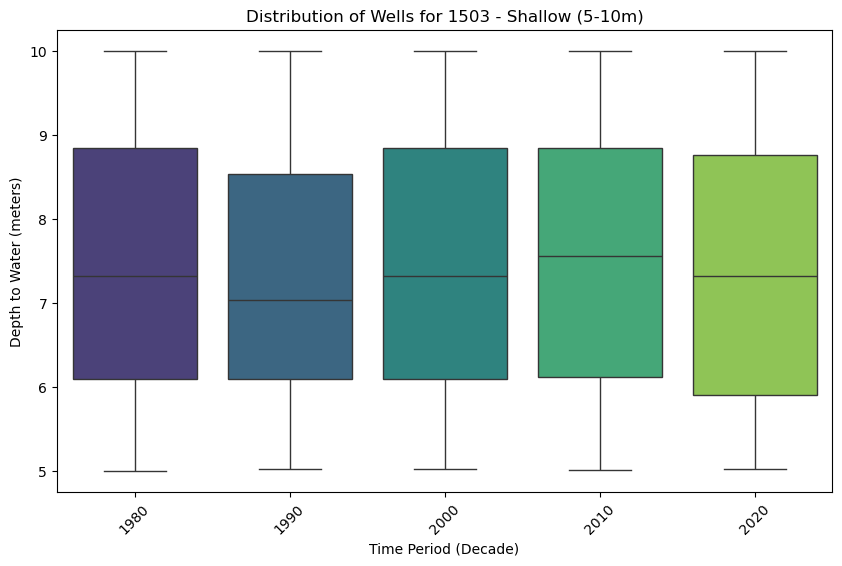

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


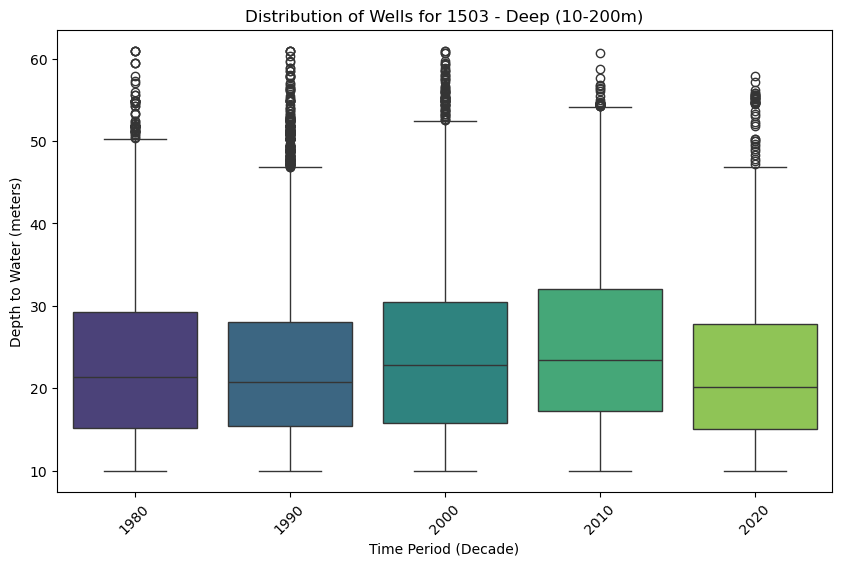

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


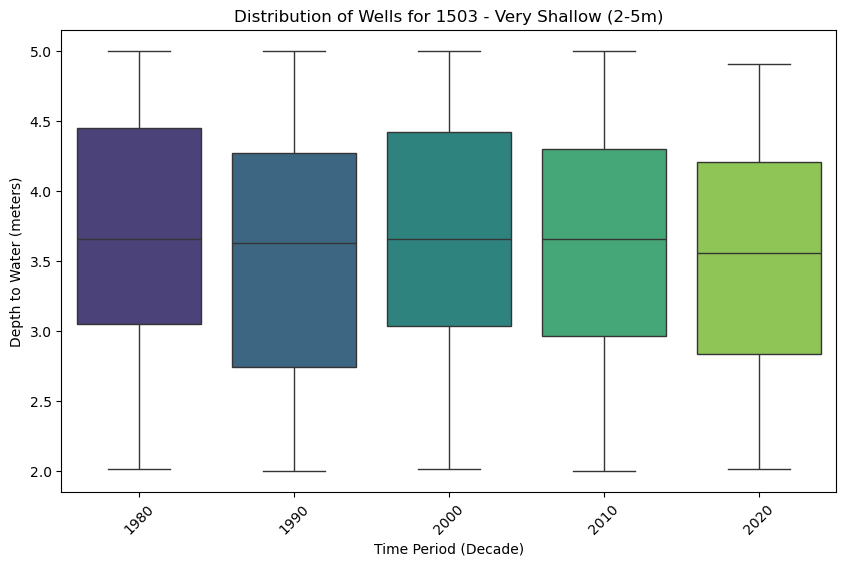

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


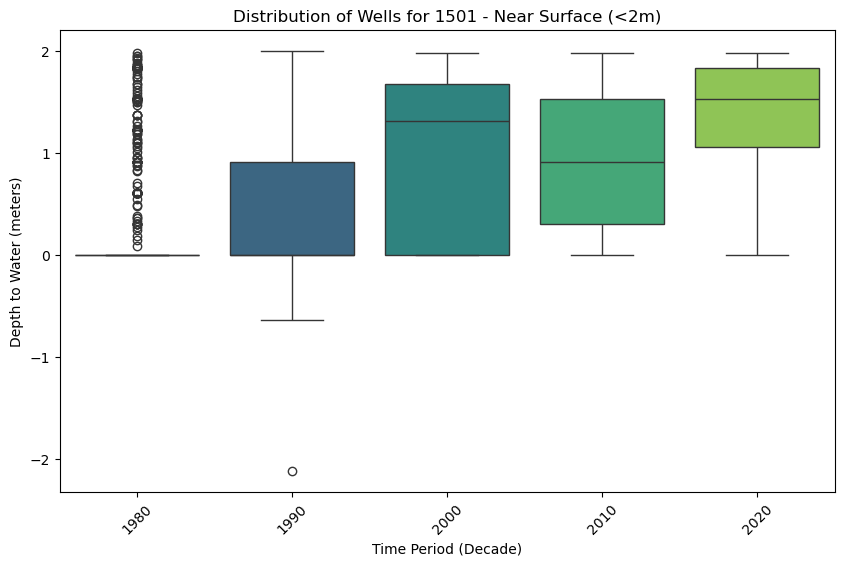

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


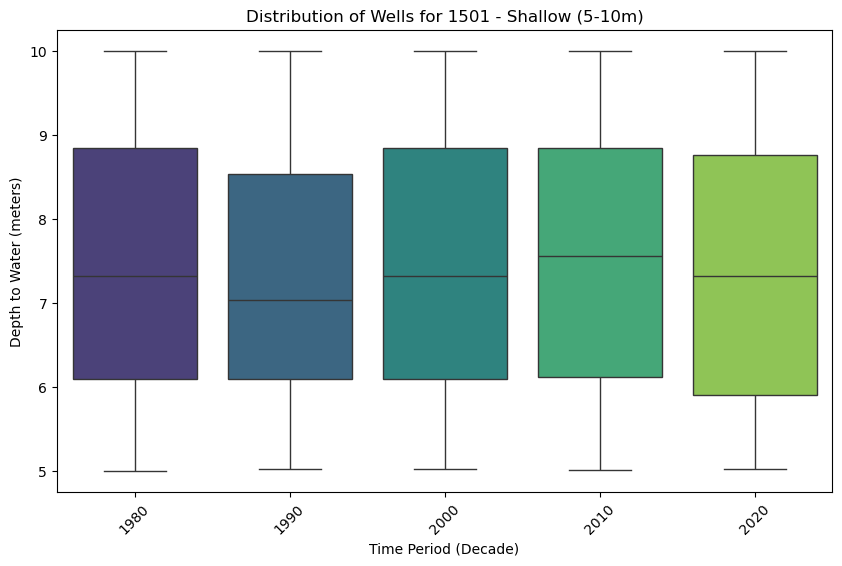

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


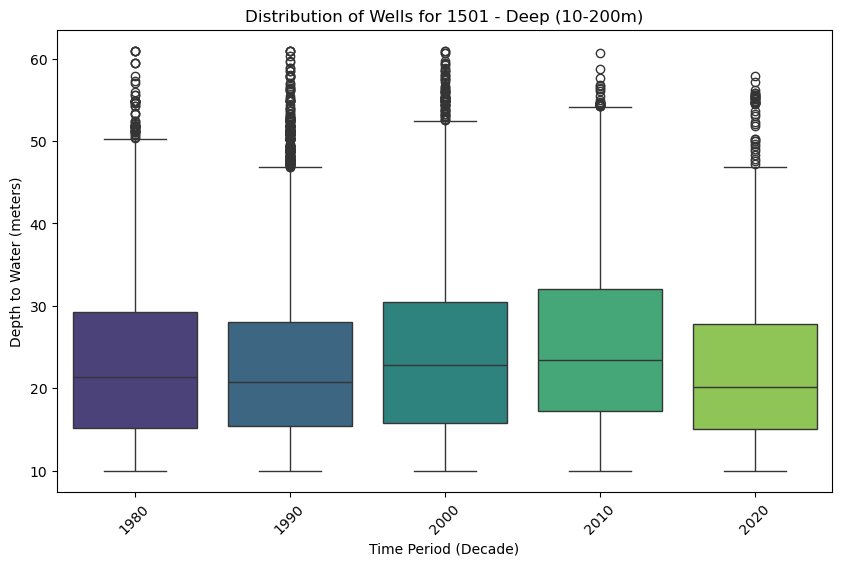

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


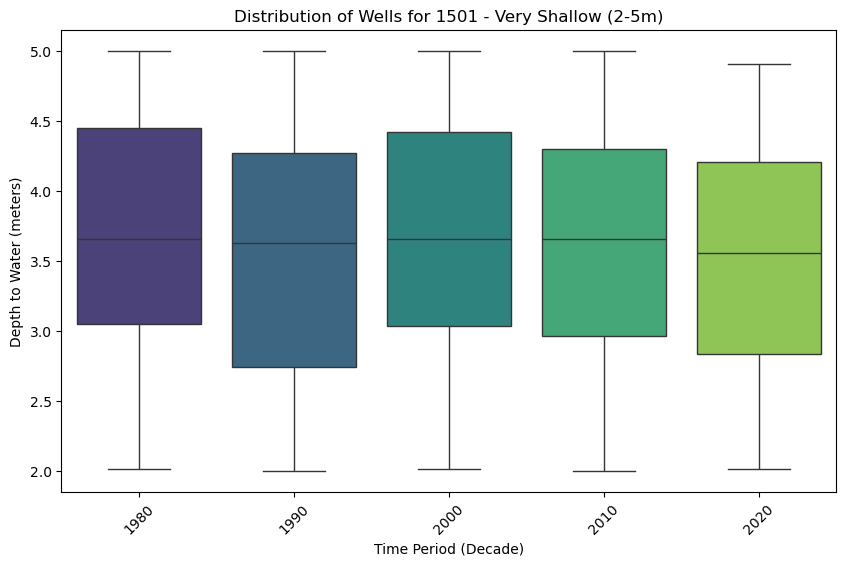

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


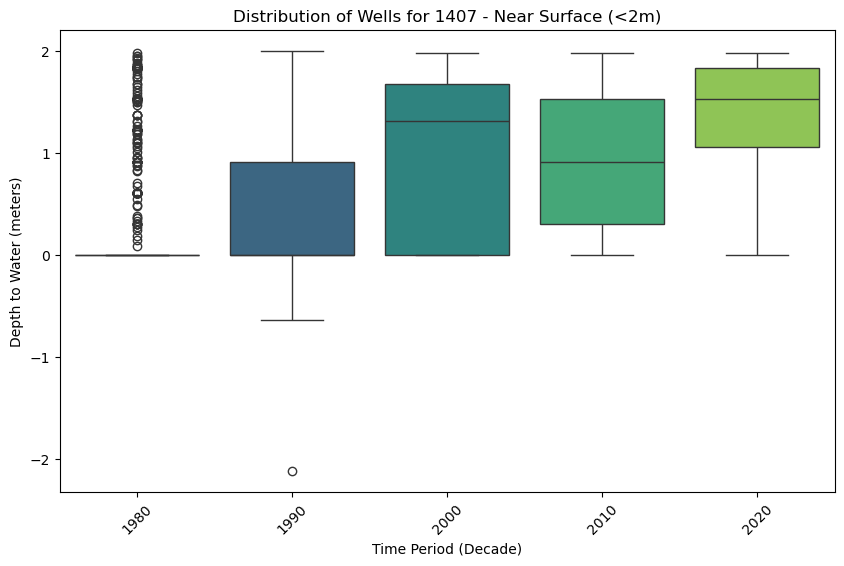

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


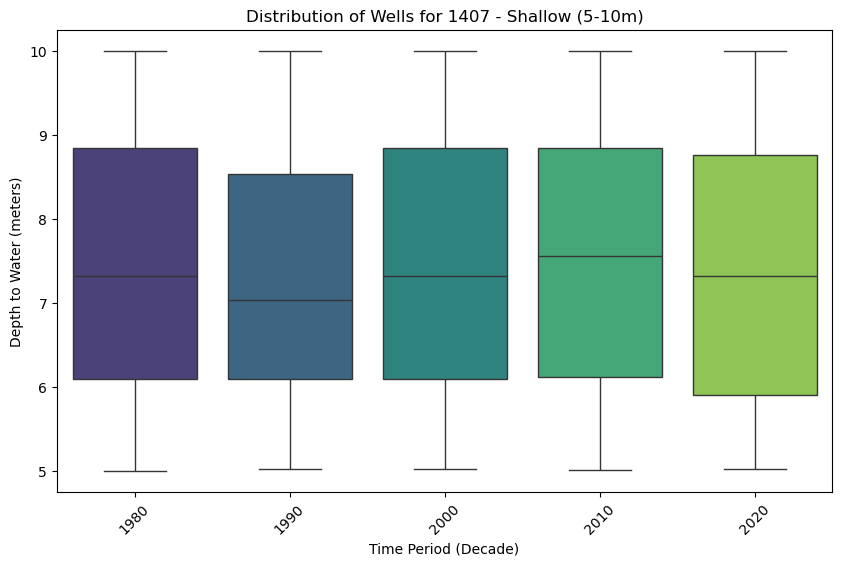

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


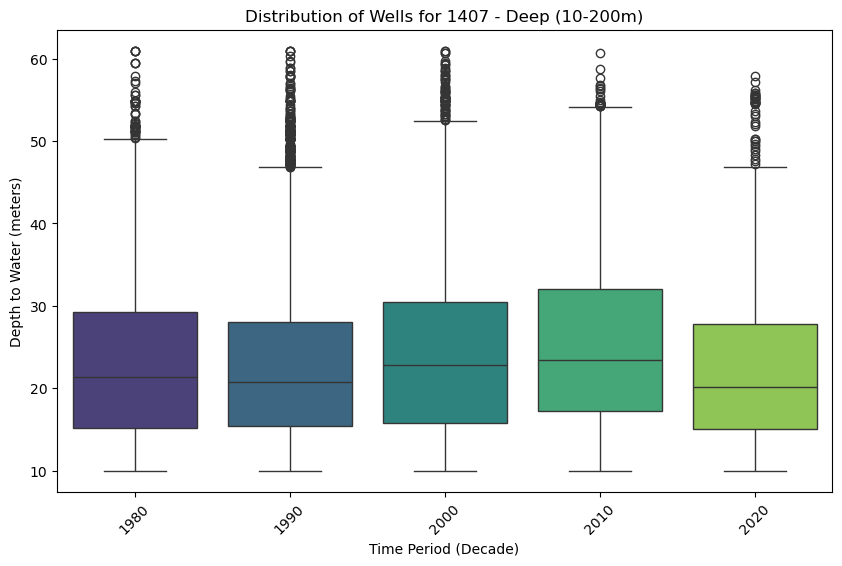

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


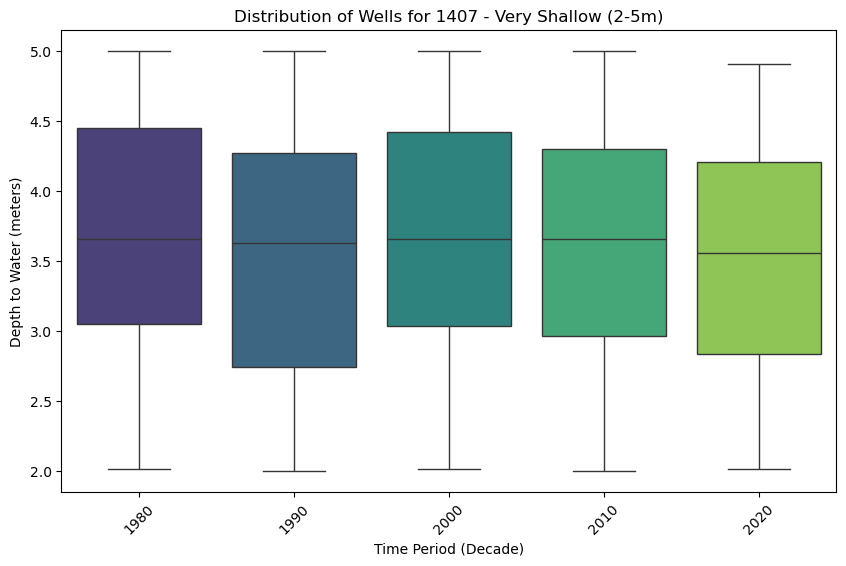

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


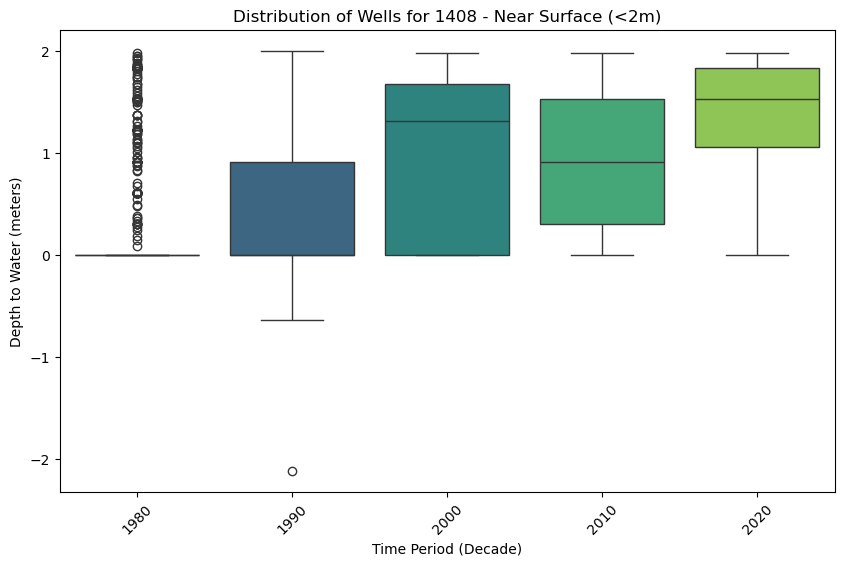

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


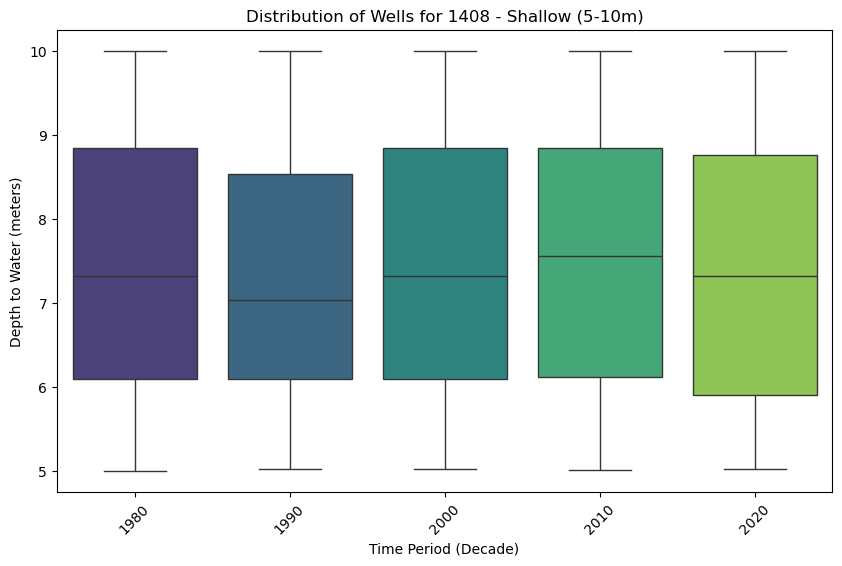

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


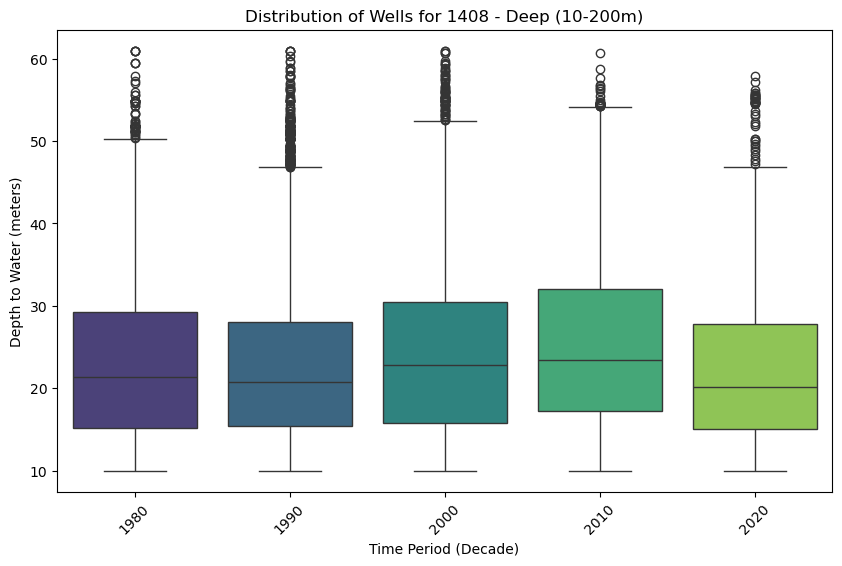

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_42629/1608626888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')


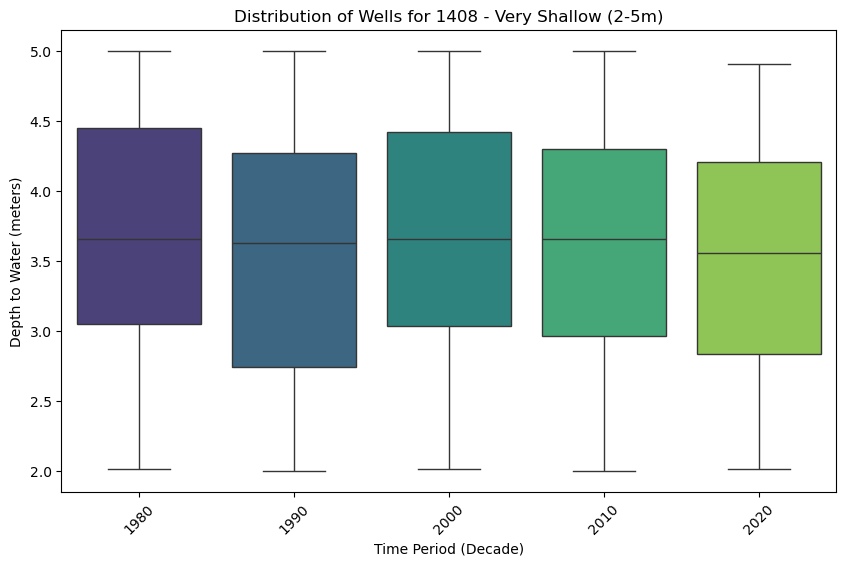

In [86]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()

# Loop through each DTW category and create a box plot
for bitch in listofhucs:
    for category in dtw_categories:
        plt.figure(figsize=(10, 6))
        
        # Subset data for the current category
        subset = df_melted[df_melted['DTW_Category'] == category]

        # Create the box plot
        sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')

        # Titles and labels
        plt.title(f'Distribution of Wells for {bitch} - {category}')
        plt.xlabel('Time Period (Decade)')
        plt.ylabel('Depth to Water (meters)')
        plt.xticks(rotation=45)

        # Show the plot
        plt.show()

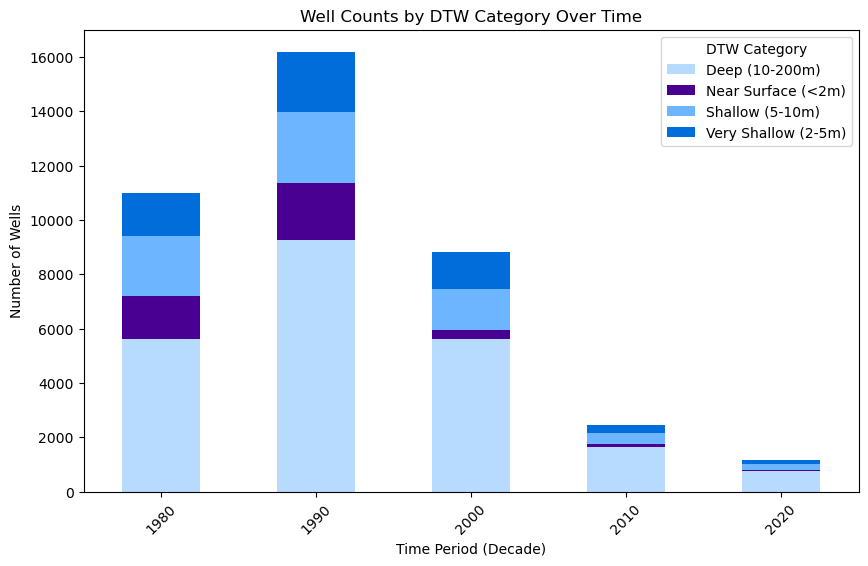

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_df.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Wells')
plt.title('Well Counts by DTW Category Over Time')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


This is where we do the above but to river lengths of different distances

In [ ]:
# Would like to turn a bunch of code into a for-loop

distances = [100, 
            #  500, 
            #  1000, 
            #  1500, 
            #  2000
             ]

sgdb_distances = {}  # Dictionary to store static databases
combo_distances = {} # Dictionary to store combo databases

for i in distances:
    # mdb = masterdb.set_crs(epsg=26912)
    mdb = static_geo.copy()
    b = shapefile.copy()
    b = b.to_crs(3857)
    b['geometry'] = b.geometry.buffer(i)
    b = b.to_crs(epsg=26912)
    sgdb_distances[f"sgdb_{i}m"] = gp.sjoin(mdb, b, how="inner", 
                                        # , op='intersects' 
                                          predicate="intersects"
                                          )

    print(f"{filename_mdb_nd} and {i}m shapefile join complete.")
    # sgdb_distances[f"sgdb_{i}m"].plot()
    sgdb_i = sgdb_distances[f"sgdb_{i}m"]

    # Export the buffered shapefile for creating maps
    # buffered.to_file(f'{outputpath}/{StudyArea}bufferedflowlines_{distance}m.shp')
    
    reg_list = sgdb_i[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_','reachcode'
                # ,'fcode','hydroseq'
                  ]]

    # Converting Combo_ID to int
    reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

    # Merging the Timeseries and the shapefile static database
    combo_distances[f"sgdb_{i}m"] = annual_db2.merge(reg_list, how="inner")
    combo_i = combo_distances[f"sgdb_{i}m"]

    # set index to Combo_ID
    combo_i.set_index('Combo_ID', inplace=True)
    combo_i = combo_i[(combo_i['WELL_DEPTH']<=200)&(combo_i['WELL_DEPTH']>0)]
    combo_i = combo_i.reset_index()  # Moves well_ID from index to a column (if needed)
    # Makes sure wells aren't being counted twice
    combo_i = combo_i.drop_duplicates(subset=["Combo_ID", Naming_col])
    combo_i = combo_i.set_index("Combo_ID")

    # Gets it ready for stats
    combo_i = combo_i.drop(['WELL_DEPTH','WELL_TYPE_','nan','reachcode'
                            # ,'fcode','hydroseq'
                            ],axis=1)

    # Makes sure we don't get any deep readings.  Might not include this in the analysis
    df = combo_i
    # Step 1: Filter columns for readings after 1980
    date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
    # Step 2: Find wells with any reading > 200 ft in these columns
    mask = (df[date_cols] > 200).any(axis=1)
    # Step 3: Drop wells that meet this condition
    df_filtered = df[~mask]
    # Now df_filtered contains only wells that never exceeded 200 ft after 1980
    combo_i = df_filtered

combo_i

Master_ADWR_database_noduplicates.shp and 100m shapefile join complete.


C:\Users\det19\AppData\Local\Temp\ipykernel_29504\579874107.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


KeyError: "['nan'] not found in axis"